In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [4]:
# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor()            # Convert images to tensor
])

# Load the training dataset
train_dataset = ImageFolder(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    transform=transform
)

# Load the validation dataset
val_dataset = ImageFolder(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    transform=transform
)

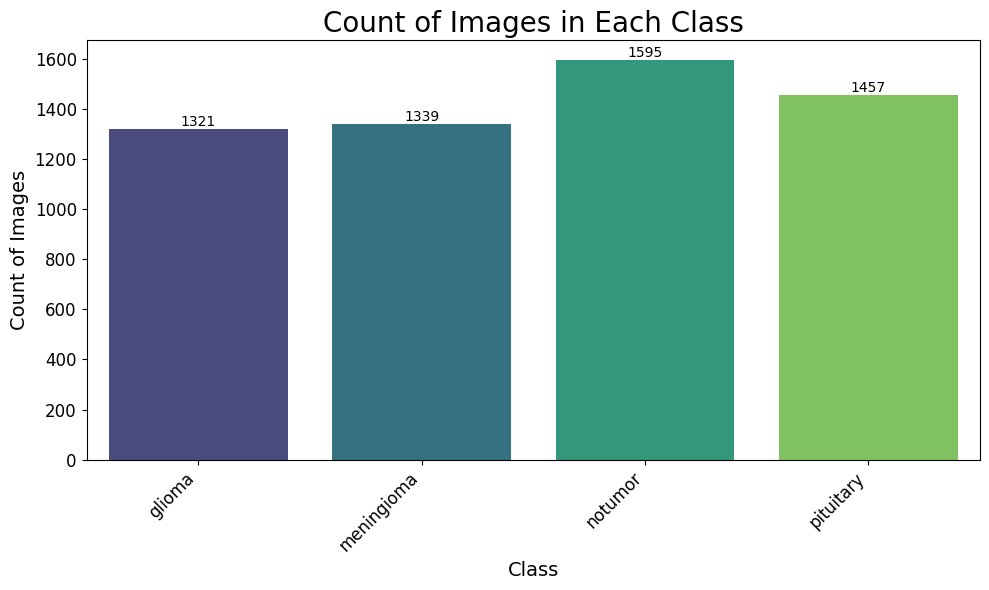

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Class': [train_dataset.classes[i] for i in train_dataset.targets]
}
tr_df = pd.DataFrame(data)

# Plot the count of images in each class
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=tr_df, x='Class', palette='viridis')

# Adding labels and title
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count of Images', fontsize=14)
plt.title('Count of Images in Each Class', fontsize=20)

# Adding bar labels
ax.bar_label(ax.containers[0])

# Customize the ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transform = transforms.Compose([  
    transforms.Resize((224, 224)),  # resize images to 224x224 pixels
    transforms.RandomRotation(25),   # randomly rotate images up to 25 degrees
    transforms.RandomHorizontalFlip(),  # randomly flip images horizontally
    transforms.RandomVerticalFlip(),    # randomly flip images vertically
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(  
        mean=mean,  # normalize with calculated mean
        std=std     # normalize with calculated std deviation
    )
])

In [7]:
train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transform)
val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  
# create data loader for training dataset, shuffling to randomize order

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  
# create data loader for validation dataset, maintaining order

In [9]:
data_iter = iter(train_loader)  # create an iterator for the training data loader
images, labels = next(data_iter)  # get the next batch of images and labels

In [10]:
images = (images.numpy().transpose([0, 2, 3, 1]) * std + mean).clip(0, 1)  
# convert images to numpy, rearrange dimensions to (batch, height, width, channels)
# apply inverse normalization by multiplying with std and adding mean
# clip values to ensure they stay between 0 and 1

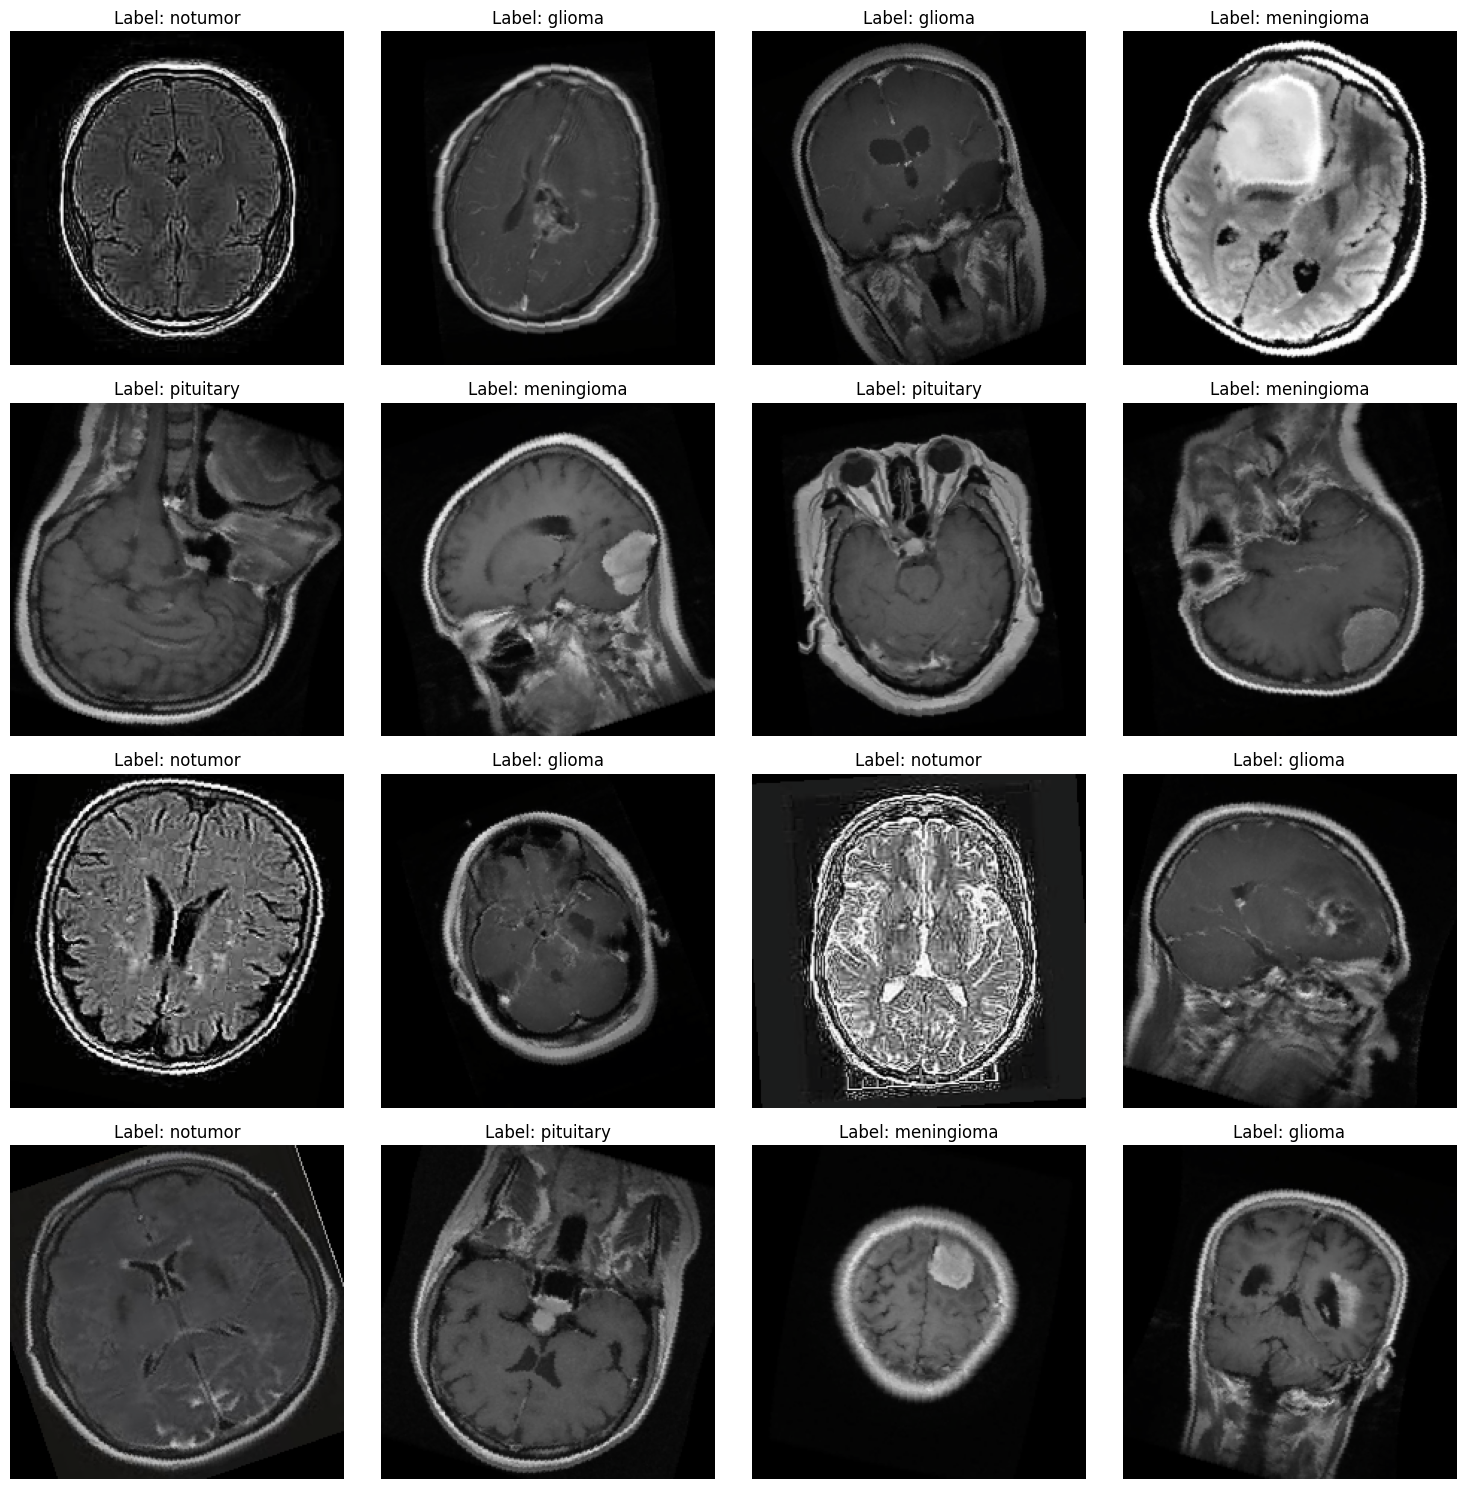

In [11]:
num_images = len(images)  # get the number of images in the batch
rows = int(np.ceil(num_images / 4))  # calculate the number of rows needed for 4 images per row
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))  # create a grid of subplots

for i, ax in enumerate(axes.flat):  
    if i >= num_images:  # stop if we've displayed all images
        break
    ax.imshow(images[i])  # show the image
    ax.set_title(f"Label: {train_dataset.classes[labels[i]]}")  # set the title with the corresponding label
    ax.axis('off')  # turn off axis ticks

plt.tight_layout()  # adjust layout to prevent overlap
plt.show()  # display the plot

In [12]:
class TumorClassification(nn.Module):  
    def __init__(self, num_classes):  
        super(TumorClassification, self).__init__()  # initialize the parent class
        self.features = nn.Sequential(  # define the feature extraction layers
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # conv layer with 3 input channels, 16 output channels
            nn.ReLU(inplace=True),  # activation function
            nn.MaxPool2d(kernel_size=3, padding=1),  # pooling layer
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),  # another activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # downsampling
        )
        self.classifier = nn.Sequential(  # define the classification layers
            nn.Linear(32 * 37 * 37, 128),  # fully connected layer
            nn.ReLU(inplace=True),  # activation
            nn.Linear(128, num_classes)  # output layer
        )

    def forward(self, x):  
        x = self.features(x)  # pass input through feature extractor
#         print(x.shape)
        x = x.view(x.size(0), -1)  # flatten the output
        x = self.classifier(x)  # pass through classifier
        return x  # return final output

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# set device to GPU if available, otherwise use CPU

model = TumorClassification(num_classes=4)  # initialize the model for 4 classes
model.to(device)  # move the model to the selected device

TumorClassification(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=43808, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [14]:
criterion = nn.CrossEntropyLoss()  # define loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # set up Adam optimizer with a learning rate of 0.001

train_losses = []  # list to store training losses
val_losses = []    # list to store validation losses
train_accuracies = []  # list to store training accuracies
val_accuracies = []     # list to store validation accuracies

In [15]:
epochs = 25  # set number of epochs for training
best_val_acc = 0.0  # initialize best validation accuracy

for epoch in range(epochs):
    model.train()  # set the model to training mode
    train_loss = 0.0  # initialize training loss
    correct = 0  # initialize correct predictions counter
    total = 0  # initialize total predictions counter

    for batch_ind, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # move data to the selected device
        
        optimizer.zero_grad()  # reset gradients
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backpropagation
        optimizer.step()  # update weights
        
        train_loss += loss.item()  # accumulate training loss
        _, predicted = torch.max(outputs, 1)  # get predicted class
        total += labels.size(0)  # update total count
        correct += (predicted == labels).sum().item()  # update correct count

    train_accuracy = correct / total  # calculate training accuracy
    train_losses.append(train_loss)  # record training loss
    train_accuracies.append(train_accuracy)  # record training accuracy
    
    model.eval()  # set the model to evaluation mode
    val_loss = 0.0  # initialize validation loss
    correct = 0  # reset correct predictions for validation
    total = 0  # reset total predictions for validation
    
    with torch.no_grad():  # disable gradient tracking
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # move data to the selected device
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # calculate loss
            
            val_loss += loss.item()  # accumulate validation loss
            _, prediction = torch.max(outputs, 1)  # get predicted class
            total += labels.size(0)  # update total count
            correct += (prediction == labels).sum().item()  # update correct count

    val_loss /= len(val_loader)  # average validation loss
    val_accuracy = correct / total  # calculate validation accuracy
    val_losses.append(val_loss)  # record validation loss
    val_accuracies.append(val_accuracy)  # record validation accuracy
    
    # print progress for the current epoch
    print(f'Epoch [{epoch + 1} of {epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')
    
    # save the model if validation accuracy improves
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # save the model state

Epoch [1 of 25], Training Loss: 248.5898, Training Accuracy: 73.56%, Validation Loss: 0.5717, Validation Accuracy: 76.51%
Epoch [2 of 25], Training Loss: 162.2495, Training Accuracy: 83.04%, Validation Loss: 0.4631, Validation Accuracy: 81.62%
Epoch [3 of 25], Training Loss: 127.5093, Training Accuracy: 86.62%, Validation Loss: 0.3769, Validation Accuracy: 85.20%
Epoch [4 of 25], Training Loss: 106.7552, Training Accuracy: 89.18%, Validation Loss: 0.4028, Validation Accuracy: 85.20%
Epoch [5 of 25], Training Loss: 89.8842, Training Accuracy: 90.46%, Validation Loss: 0.3657, Validation Accuracy: 87.34%
Epoch [6 of 25], Training Loss: 79.8531, Training Accuracy: 92.28%, Validation Loss: 0.2667, Validation Accuracy: 90.08%
Epoch [7 of 25], Training Loss: 71.6255, Training Accuracy: 92.70%, Validation Loss: 0.2380, Validation Accuracy: 91.30%
Epoch [8 of 25], Training Loss: 62.2275, Training Accuracy: 93.86%, Validation Loss: 0.2068, Validation Accuracy: 91.91%
Epoch [9 of 25], Training Lo

In [16]:
print(f'Validation Accuracy: {best_val_acc:.2%}')

Validation Accuracy: 96.49%


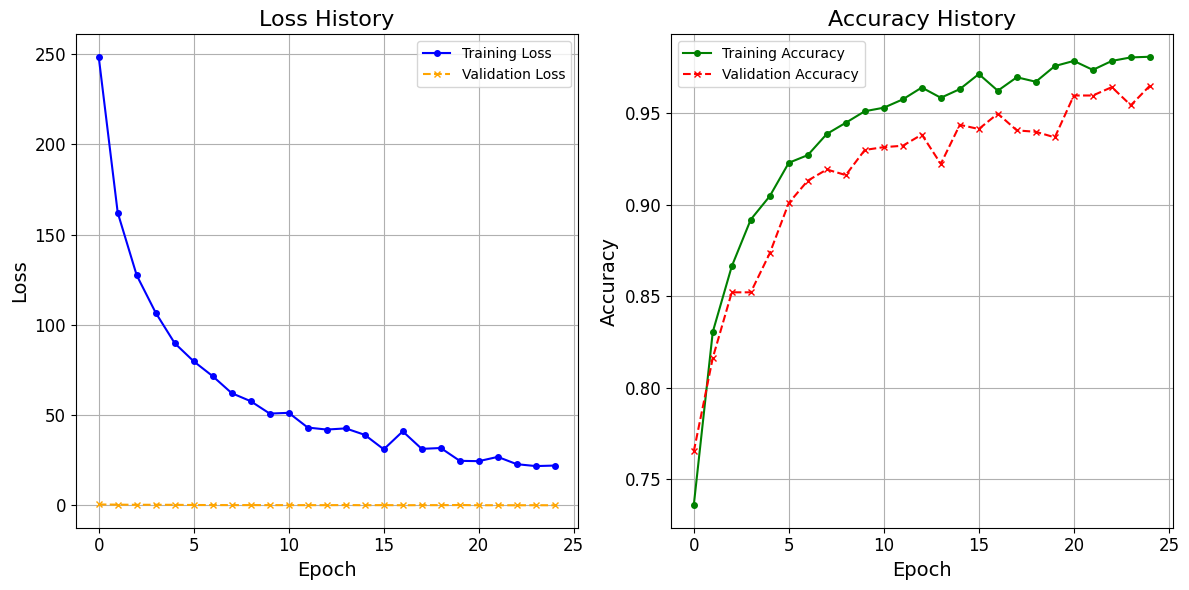

In [17]:
import matplotlib.pyplot as plt  # import matplotlib for plotting

plt.figure(figsize=(12, 6))  # create a figure with specified size

# Training and Validation Loss
plt.subplot(1, 2, 1)  # create a subplot for loss
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)  
# plot training loss
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x', markersize=4)  
# plot validation loss
plt.xlabel('Epoch', fontsize=14)  # label for x-axis
plt.ylabel('Loss', fontsize=14)    # label for y-axis
plt.title('Loss History', fontsize=16)  # title of the plot
plt.legend()  # show legend
plt.grid(True)  # add grid
plt.xticks(fontsize=12)  # set x-tick font size
plt.yticks(fontsize=12)  # set y-tick font size

# Training and Validation Accuracy
plt.subplot(1, 2, 2)  # create a subplot for accuracy
plt.plot(train_accuracies, label='Training Accuracy', color='green', linestyle='-', marker='o', markersize=4)  
# plot training accuracy
plt.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--', marker='x', markersize=4)  
# plot validation accuracy
plt.xlabel('Epoch', fontsize=14)  # label for x-axis
plt.ylabel('Accuracy', fontsize=14)  # label for y-axis
plt.title('Accuracy History', fontsize=16)  # title of the plot
plt.legend()  # show legend
plt.grid(True)  # add grid
plt.xticks(fontsize=12)  # set x-tick font size
plt.yticks(fontsize=12)  # set y-tick font size

plt.tight_layout()  # adjust layout to prevent overlap
plt.show()  # display the plots

In [18]:
import random  # import random for selecting random images

def get_random_images(dataset, num_images_per_class=1):  
    class_to_images = {}  # dictionary to store images by class

    for img, label in dataset:  # loop through dataset
        if label not in class_to_images:  # if class not in dictionary
            class_to_images[label] = []  # initialize list for that class
        class_to_images[label].append(img)  # add image to the corresponding class

    random_images = []  # list to hold randomly selected images

    for label, images in class_to_images.items():  # loop through each class
        selected_images = random.sample(images, min(num_images_per_class, len(images)))  
        # randomly select images from the class
        random_images.extend((img, label) for img in selected_images)  # add selected images to the list

    return random_images  # return the list of random images

In [19]:
random_images = get_random_images(val_dataset)

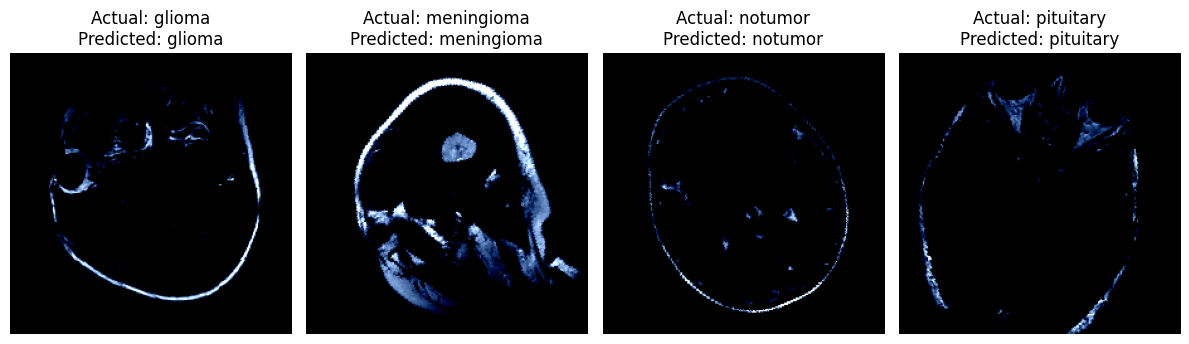

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(12, 12))  # create a subplot for displaying images
axes = axes.flatten()  # flatten the axes array for easy indexing
class_names = val_dataset.classes  # get class names from the validation dataset

for i, (image, actual_label) in enumerate(random_images):  # loop through random images
    image = image.unsqueeze(0).to(device)  # add batch dimension and move to device
    with torch.no_grad():  # disable gradient tracking
        output = model(image)  # get model predictions
        _, predicted_label = torch.max(output, 1)  # get the predicted class
    
    image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # reshape image for plotting
    
    axes[i].imshow(image)  # display the image
    axes[i].set_title(f'Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label.item()]}')  
    # set the title with actual and predicted labels
    axes[i].axis('off')  # turn off axis ticks

plt.tight_layout()  # adjust layout to prevent overlap
plt.show()  # display the plots